In [ ]:
pip install torch

In [ ]:
pip install transformers

In [ ]:
pip install scikit-learn

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertTokenizer, DistilBertModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

In [ ]:
import pandas as pd

In [ ]:
# Load the DataFrame from the CSV file
df = pd.read_csv('/content/fake reviews dataset (1).csv')

In [ ]:
df.head()

,category,rating,label,text_
0,Home_and_Kitchen_5,5.0,CG,"Love this! Well made, sturdy, and very comfor..."
1,Home_and_Kitchen_5,5.0,CG,"love it, a great upgrade from the original. I..."
2,Home_and_Kitchen_5,5.0,CG,This pillow saved my back. I love the look and...
3,Home_and_Kitchen_5,1.0,CG,"Missing information on how to use it, but it i..."
4,Home_and_Kitchen_5,5.0,CG,Very nice set. Good quality. We have had the s...


In [ ]:
df.shape

(40432, 4)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40432 entries, 0 to 40431
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   category  40432 non-null  object 
 1   rating    40432 non-null  float64
 2   label     40432 non-null  object 
 3   text_     40432 non-null  object 
dtypes: float64(1), object(3)
memory usage: 1.2+ MB


In [ ]:
df.isnull().sum()

category    0
rating      0
label       0
text_       0
dtype: int64

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

        # Initialize a label encoder
        self.label_encoder = LabelEncoder()
        self.labels = self.label_encoder.fit_transform(labels)

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

In [ ]:
# Assuming you have a DataFrame df with 'category', 'rating', 'label', 'text_' columns
texts = df['text_'].values
labels = df['label'].values

In [ ]:
# Encode labels using LabelEncoder
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

In [ ]:
# Split the data into train and test sets
train_texts, test_texts, train_labels, test_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)


In [ ]:
# Tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [ ]:
# Create datasets and dataloaders
train_dataset = CustomDataset(train_texts, train_labels, tokenizer, max_len=128)
test_dataset = CustomDataset(test_texts, test_labels, tokenizer, max_len=128)
# Create dataloaders
batch_size = 16
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Make sure to initialize label_encoder before creating the dataset and dataloader
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(df['label'].values)

train_dataset = CustomDataset(train_texts, train_labels, tokenizer, max_len=128)
test_dataset = CustomDataset(test_texts, test_labels, tokenizer, max_len=128)

In [ ]:
#Model Definition
class DistilBERTClassifier(nn.Module):
    def __init__(self, num_classes):
        super(DistilBERTClassifier, self).__init__()
        self.distilbert = DistilBertModel.from_pretrained('distilbert-base-uncased')
        self.drop = nn.Dropout(0.3)
        self.fc = nn.Linear(self.distilbert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        output = self.distilbert(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state
        pooled_output = output[:, 0, :]  # Take the [CLS] token representation
        output = self.drop(pooled_output)
        return self.fc(output)


In [ ]:
# Instantiate the model
num_classes = len(label_encoder.classes_)
model = DistilBERTClassifier(num_classes)

In [ ]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

In [ ]:
# Training loop
epochs = 5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

for epoch in range(epochs):
    model.train()
    for batch in train_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

In [ ]:
# Switch the model to evaluation mode
model.eval()

DistilBERTClassifier(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin

In [ ]:
# Lists to store predictions and true labels
all_preds = []
all_labels = []

In [ ]:
with torch.no_grad():
    for batch in test_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids, attention_mask)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

In [ ]:
# Calculate accuracy using sklearn's accuracy_score
accuracy = accuracy_score(all_labels, all_preds)
print(f'Accuracy on the test set: {accuracy:.4f}')

Accuracy on the test set: 0.9473


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

<ipython-input-61-b83be1ef618c>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='category', data=df, palette='viridis')


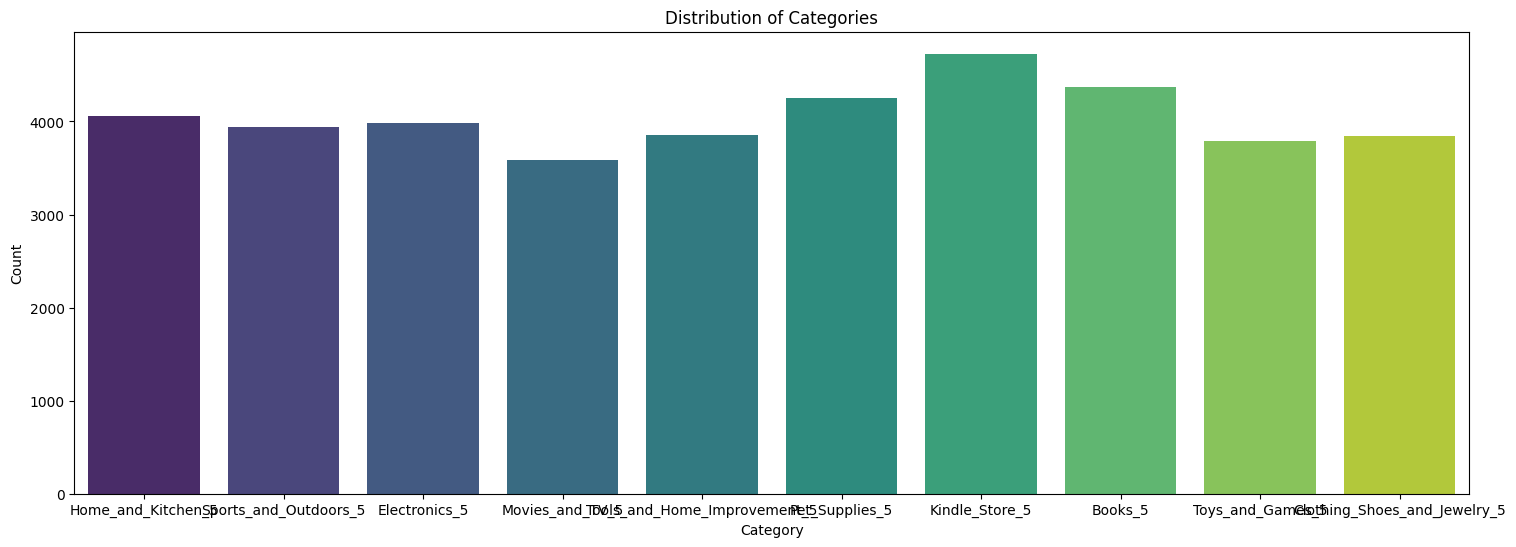

In [ ]:
# Visualize the distribution of the 'category' attribute
plt.figure(figsize=(18, 6))
sns.countplot(x='category', data=df, palette='viridis')
plt.title('Distribution of Categories')
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()


<ipython-input-62-0d21b277bd29>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='rating', data=df, palette='plasma')


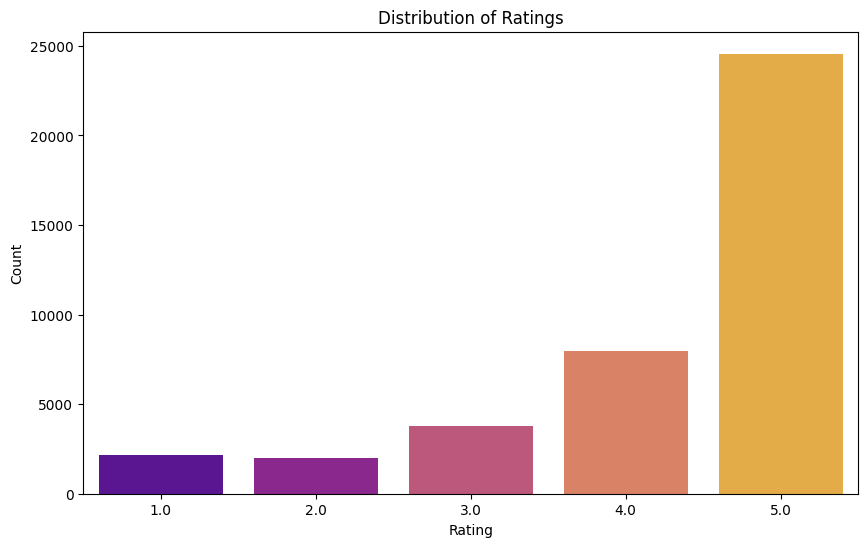

In [ ]:
# Visualize the distribution of the 'rating' attribute
plt.figure(figsize=(10, 6))
sns.countplot(x='rating', data=df, palette='plasma')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()


<ipython-input-63-90fc7265be52>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df, palette='muted')


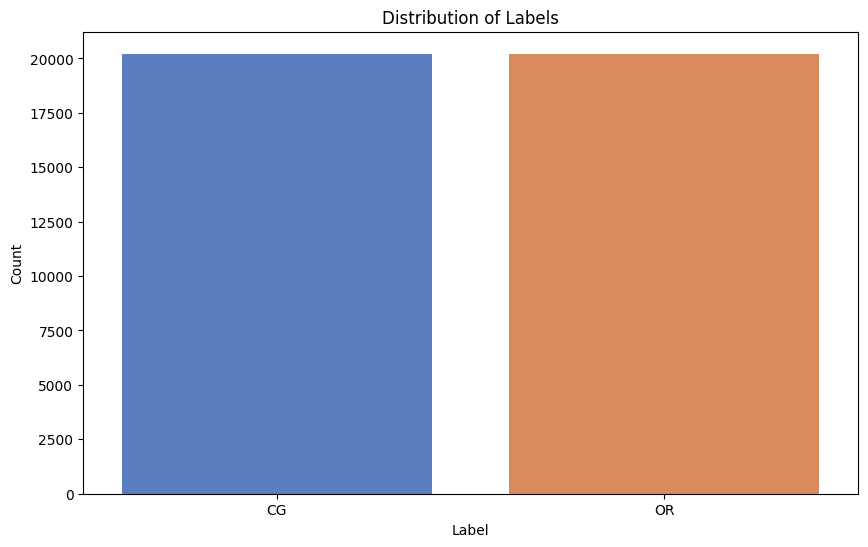

In [ ]:
# Visualize the distribution of the 'label' attribute
plt.figure(figsize=(10, 6))
sns.countplot(x='label', data=df, palette='muted')
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

In [ ]:
# Word cloud for the 'text_' attribute
from wordcloud import WordCloud

In [ ]:
text_combined = ' '.join(df['text_'].astype(str))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_combined)


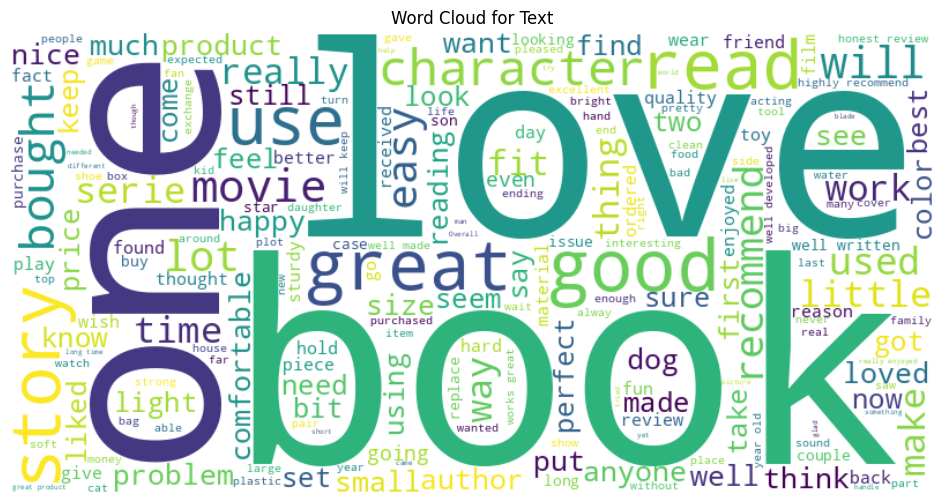

In [ ]:
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Text')
plt.show()

In [ ]:
#LSTM

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

In [ ]:
df = pd.read_csv('/content/fake reviews dataset (1).csv')

**EDA**

In [ ]:
df.head()

,category,rating,label,text_
0,Home_and_Kitchen_5,5.0,CG,"Love this! Well made, sturdy, and very comfor..."
1,Home_and_Kitchen_5,5.0,CG,"love it, a great upgrade from the original. I..."
2,Home_and_Kitchen_5,5.0,CG,This pillow saved my back. I love the look and...
3,Home_and_Kitchen_5,1.0,CG,"Missing information on how to use it, but it i..."
4,Home_and_Kitchen_5,5.0,CG,Very nice set. Good quality. We have had the s...


In [ ]:
df.tail()

,category,rating,label,text_
40427,Clothing_Shoes_and_Jewelry_5,4.0,OR,I had read some reviews saying that this bra r...
40428,Clothing_Shoes_and_Jewelry_5,5.0,CG,I wasn't sure exactly what it would be. It is ...
40429,Clothing_Shoes_and_Jewelry_5,2.0,OR,"You can wear the hood by itself, wear it with ..."
40430,Clothing_Shoes_and_Jewelry_5,1.0,CG,I liked nothing about this dress. The only rea...
40431,Clothing_Shoes_and_Jewelry_5,5.0,OR,I work in the wedding industry and have to wor...


In [ ]:
df.isnull().sum()

category    0
rating      0
label       0
text_       0
dtype: int64

In [ ]:
df.dtypes

category     object
rating      float64
label        object
text_        object
dtype: object

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40432 entries, 0 to 40431
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   category  40432 non-null  object 
 1   rating    40432 non-null  float64
 2   label     40432 non-null  object 
 3   text_     40432 non-null  object 
dtypes: float64(1), object(3)
memory usage: 1.2+ MB


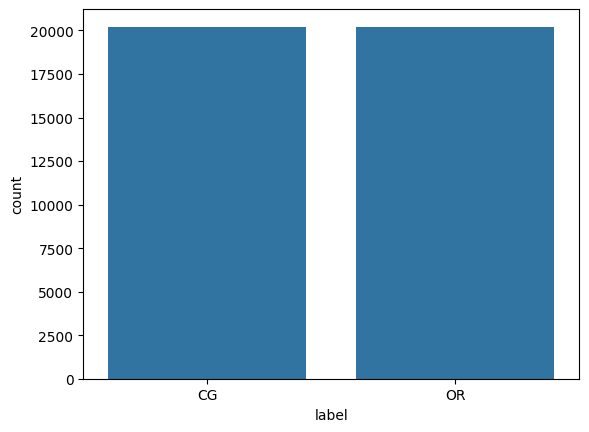

In [ ]:
#visualize class distribution
sns.countplot(x='label', data=df)
plt.show()

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['text_'], df['label'], test_size=0.2, random_state=42)

In [ ]:
# Tokenize and pad the text data
max_words = 5000
tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)


In [ ]:
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)


In [ ]:
max_len = max(len(seq) for seq in X_train_sequences)
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_len, padding='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_len, padding='post')

In [ ]:
# Encode the labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)


In [ ]:
# Build the LSTM model
embedding_dim = 50
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len))
model.add(LSTM(units=100))
model.add(Dense(units=1, activation='sigmoid'))

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
# Train the model
model.fit(X_train_padded, y_train_encoded, epochs=10, validation_data=(X_test_padded, y_test_encoded))


Epoch 1/10
1011/1011 [==============================] - 418s 409ms/step - loss: 0.6933 - accuracy: 0.4996 - val_loss: 0.6931 - val_accuracy: 0.5034
Epoch 2/10
1011/1011 [==============================] - 419s 415ms/step - loss: 0.6932 - accuracy: 0.4972 - val_loss: 0.6932 - val_accuracy: 0.4966
Epoch 3/10
1011/1011 [==============================] - 410s 405ms/step - loss: 0.6932 - accuracy: 0.5036 - val_loss: 0.6931 - val_accuracy: 0.5034
Epoch 4/10
1011/1011 [==============================] - 406s 402ms/step - loss: 0.6932 - accuracy: 0.4975 - val_loss: 0.6932 - val_accuracy: 0.4966
Epoch 5/10
1011/1011 [==============================] - 411s 407ms/step - loss: 0.6932 - accuracy: 0.5019 - val_loss: 0.6931 - val_accuracy: 0.5034
Epoch 6/10
1011/1011 [==============================] - 397s 393ms/step - loss: 0.6932 - accuracy: 0.4981 - val_loss: 0.6932 - val_accuracy: 0.4966
Epoch 7/10
1011/1011 [==============================] - 417s 413ms/step - loss: 0.6932 - accuracy: 0.4952 - val_

In [ ]:
# Evaluate the model on the test set
y_pred_prob = model.predict(X_test_padded)
y_pred = (y_pred_prob > 0.5).astype(int)

253/253 [==============================] - 35s 135ms/step


In [ ]:
# Convert predictions back to original labels
y_pred_labels = label_encoder.inverse_transform(y_pred.flatten())

In [ ]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_labels)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 49.66%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

          CG       0.50      1.00      0.66      4016
          OR       0.00      0.00      0.00      4071

    accuracy                           0.50      8087
   macro avg       0.25      0.50      0.33      8087
weighted avg       0.25      0.50      0.33      8087



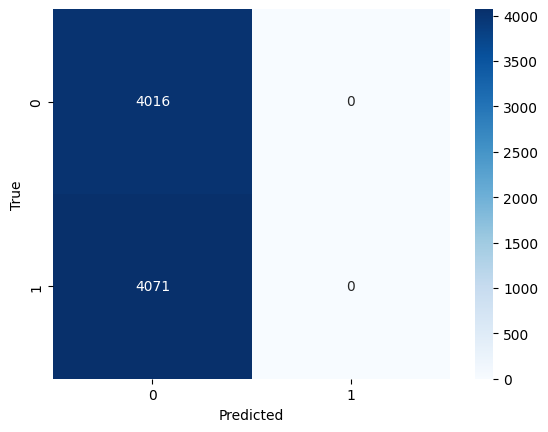

In [ ]:
# Display classification report and confusion matrix
print(classification_report(y_test, y_pred_labels))
conf_mat = confusion_matrix(y_test, y_pred_labels)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
#bi lstm

In [ ]:
!pip install textblob

In [ ]:
!pip install wordcloud

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import re, string, unicodedata
from string import punctuation
from collections import Counter
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from keras.callbacks import ReduceLROnPlateau
from bs4 import BeautifulSoup
from keras.preprocessing import text, sequence
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from textblob import Word
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud, STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.models import Sequential
import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from warnings import filterwarnings
filterwarnings('ignore')
from sklearn import set_config
set_config(print_changed_only=False)
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from termcolor import colored # Import the colored function

print(colored("\nLIBRARIES WERE SUCCESFULLY IMPORTED...", "red"))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...



LIBRARIES WERE SUCCESFULLY IMPORTED...


[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
# Loading Data
df = pd.read_csv("/content/fake reviews dataset (1).csv")

In [ ]:
# Read the true news
df.head()

,category,rating,label,text_
0,Home_and_Kitchen_5,5,CG,"Love this! Well made, sturdy, and very comfor..."
1,Home_and_Kitchen_5,5,CG,"love it, a great upgrade from the original. I..."
2,Home_and_Kitchen_5,5,CG,This pillow saved my back. I love the look and...
3,Home_and_Kitchen_5,1,CG,"Missing information on how to use it, but it i..."
4,Home_and_Kitchen_5,5,CG,Very nice set. Good quality. We have had the s...


In [ ]:
print("The shape of df: ", df.shape)

The shape of df:  (40432, 4)


In [ ]:
# Show the information for the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40432 entries, 0 to 40431
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  40432 non-null  object
 1   rating    40432 non-null  int64 
 2   label     40432 non-null  object
 3   text_     40432 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.2+ MB


In [ ]:
#check the null value
df.isna().sum()

category    0
rating      0
label       0
text_       0
dtype: int64

In [ ]:
# calculate the duplicate
print("The Number of duplicate :",df.duplicated().sum() )

The Number of duplicate : 12


In [ ]:
# Here we can delet the duplicate
print("Remove The duplicate:",df.drop_duplicates(inplace=True))

Remove The duplicate: None


In [ ]:
# check the value count of the classes we have in the data
print("The count of labels: \n", df.label.value_counts())

The count of labels: 
 label
OR    20215
CG    20205
Name: count, dtype: int64


In [ ]:
# Check the value of category
print("The value count of category : \n", df.category.value_counts())

The value count of category : 
 category
Kindle_Store_5                  4728
Books_5                         4369
Pet_Supplies_5                  4251
Home_and_Kitchen_5              4056
Electronics_5                   3988
Sports_and_Outdoors_5           3944
Tools_and_Home_Improvement_5    3858
Clothing_Shoes_and_Jewelry_5    3847
Toys_and_Games_5                3792
Movies_and_TV_5                 3587
Name: count, dtype: int64


In [ ]:
# Check the value count for the rating
print("The value count of rating : \n", df.rating.value_counts())

The value count of rating : 
 rating
5    24547
4     7965
3     3786
1     2155
2     1967
Name: count, dtype: int64


In [ ]:
# Check the value count for the text_
print("The value count of text_ : \n", df.text_.value_counts())

The value count of text_ : 
 text_
These are very comfortable.  They have the wide width which is perfect.  They are warm and                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

In [ ]:
#Data visualization

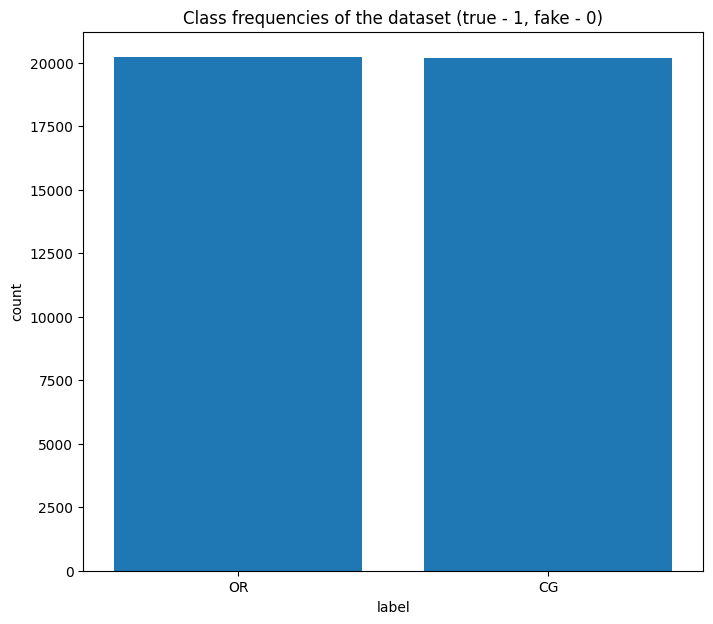

In [ ]:
plt.figure(figsize = [8, 7], clear = True, facecolor = 'white')

sns.barplot(x = df["label"].value_counts().index,
            y = df["label"].value_counts(),
            saturation = 1).set(title = "Class frequencies of the dataset (true - 1, fake - 0)");

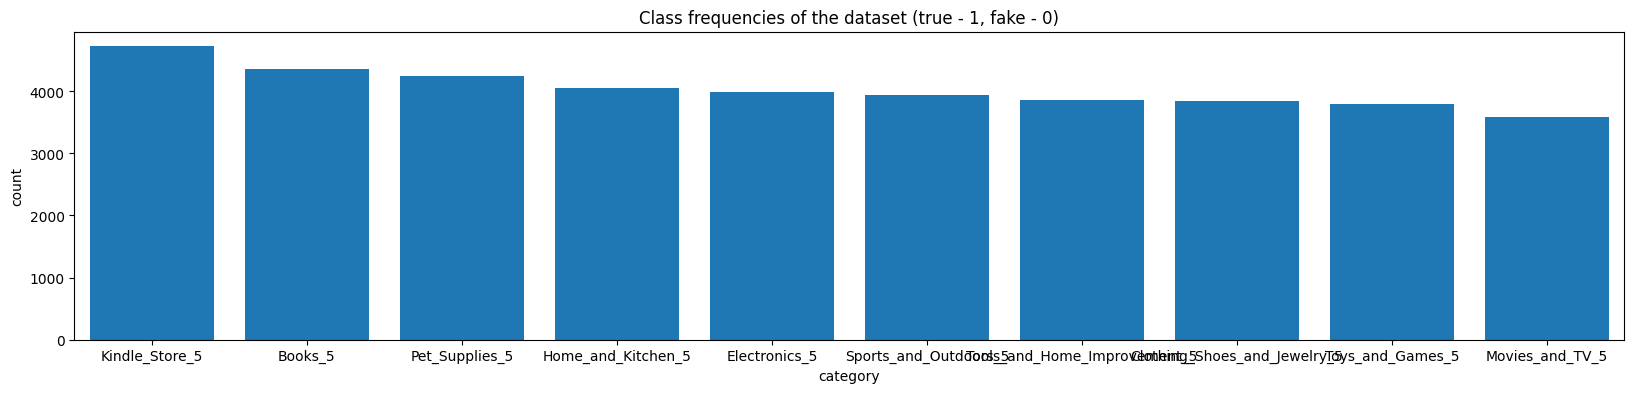

In [ ]:
plt.figure(figsize = [20, 4], clear = False, facecolor = 'white',edgecolor='black')
sns.barplot(x = df["category"].value_counts().index,
            y = df["category"].value_counts(),
            saturation = 1).set(title = "Class frequencies of the dataset (true - 1, fake - 0)");

In [ ]:
fig = px.pie(data_frame = df, names = "label", hole = 0.4, title = "counts in label",
             width = 1000, height = 500, color_discrete_sequence = px.colors.sequential.Sunset_r)

fig.update_traces(textposition = "inside", textinfo = "percent+label",
                  marker = dict(line = dict(width = 1.2, color = "#000000")))

fig.update_layout(title_x = 0.5, title_font = dict(size = 30), uniformtext_minsize = 25)

fig.show()

In [ ]:
fig = px.pie(df, names = "category", title = "counts in label", hole = 0.5,
            width = 1000, height = 500, color_discrete_sequence = px.colors.sequential.Sunset_r)

fig.update_traces(textposition = "inside", textinfo = "percent+label",
                  marker = dict(line = dict(width = 1.2, color = "#000000")))

fig.update_layout(title_x = 0.5, title_font = dict(size = 30), uniformtext_minsize = 25)

fig.show()

In [ ]:
pip install wordcloud matplotlib pandas


In [ ]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt


In [ ]:
text_combined = ' '.join(df['text_'].astype(str).tolist())

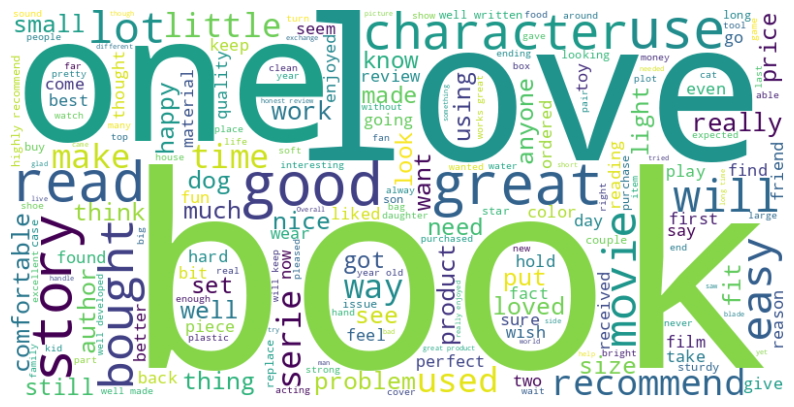

In [ ]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_combined)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


In [ ]:
#data cleaning

In [ ]:
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

In [ ]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
# Removing URL's
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)
#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)
#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text
#Apply function on review column
df['text_']=df['text_'].apply(denoise_text)

In [ ]:
def get_corpus(text):
    words = []
    for i in text:
        for j in i.split():
            words.append(j.strip())
    return words
corpus = get_corpus(df.text_)
corpus[:5]

['Love', 'this!', 'Well', 'made,', 'sturdy,']

In [ ]:
from collections import Counter
counter = Counter(corpus)
most_common = counter.most_common(10)
most_common = dict(most_common)
most_common

{'would': 10046,
 'one': 10042,
 'book': 9984,
 'good': 9936,
 'great': 9656,
 'love': 9239,
 'like': 8903,
 'it.': 8259,
 'little': 7986,
 'well': 7416}

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
def get_top_text_ngrams(corpus, n, g):
    vec = CountVectorizer(ngram_range=(g, g)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [ ]:
#calculate the unigram analysis

<Axes: >

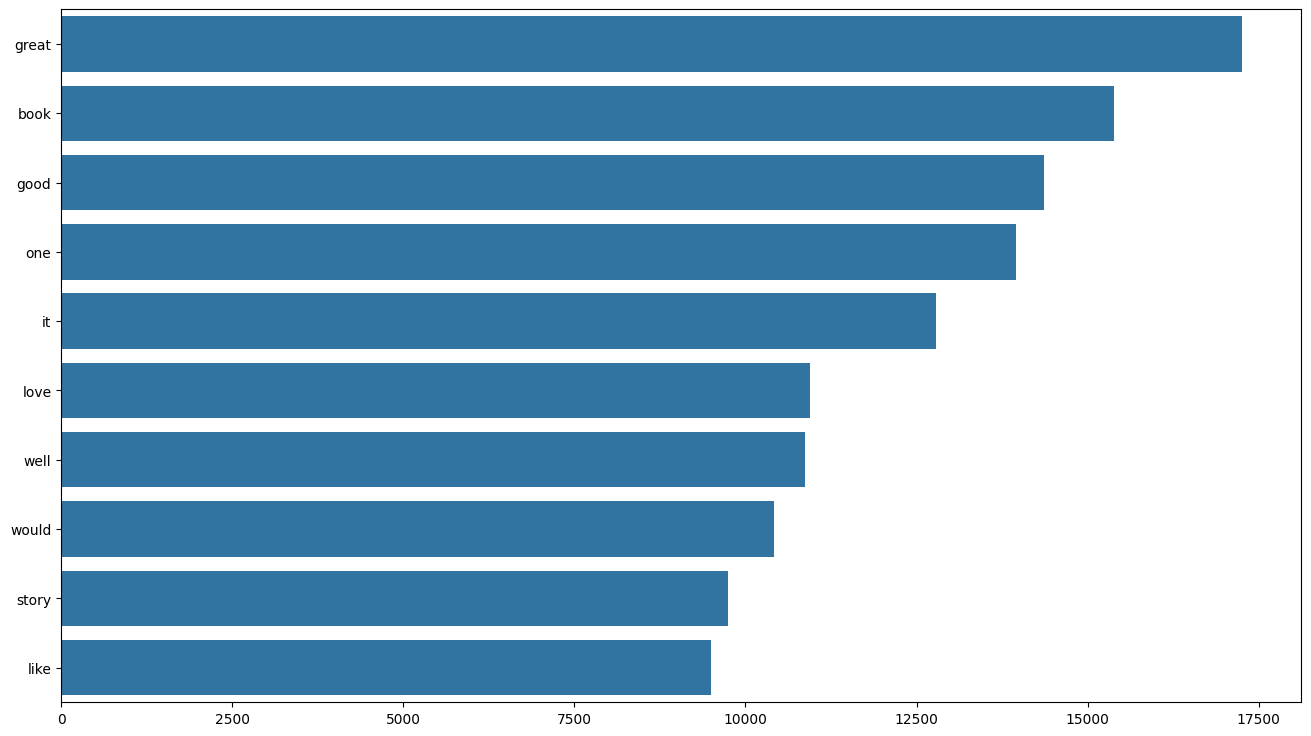

In [ ]:
plt.figure(figsize = (16,9))
most_common_uni = get_top_text_ngrams(df.text_,10,1)
most_common_uni = dict(most_common_uni)
sns.barplot(x=list(most_common_uni.values()),y=list(most_common_uni.keys()))

In [ ]:
#calculate the bigram analysis

<Axes: >

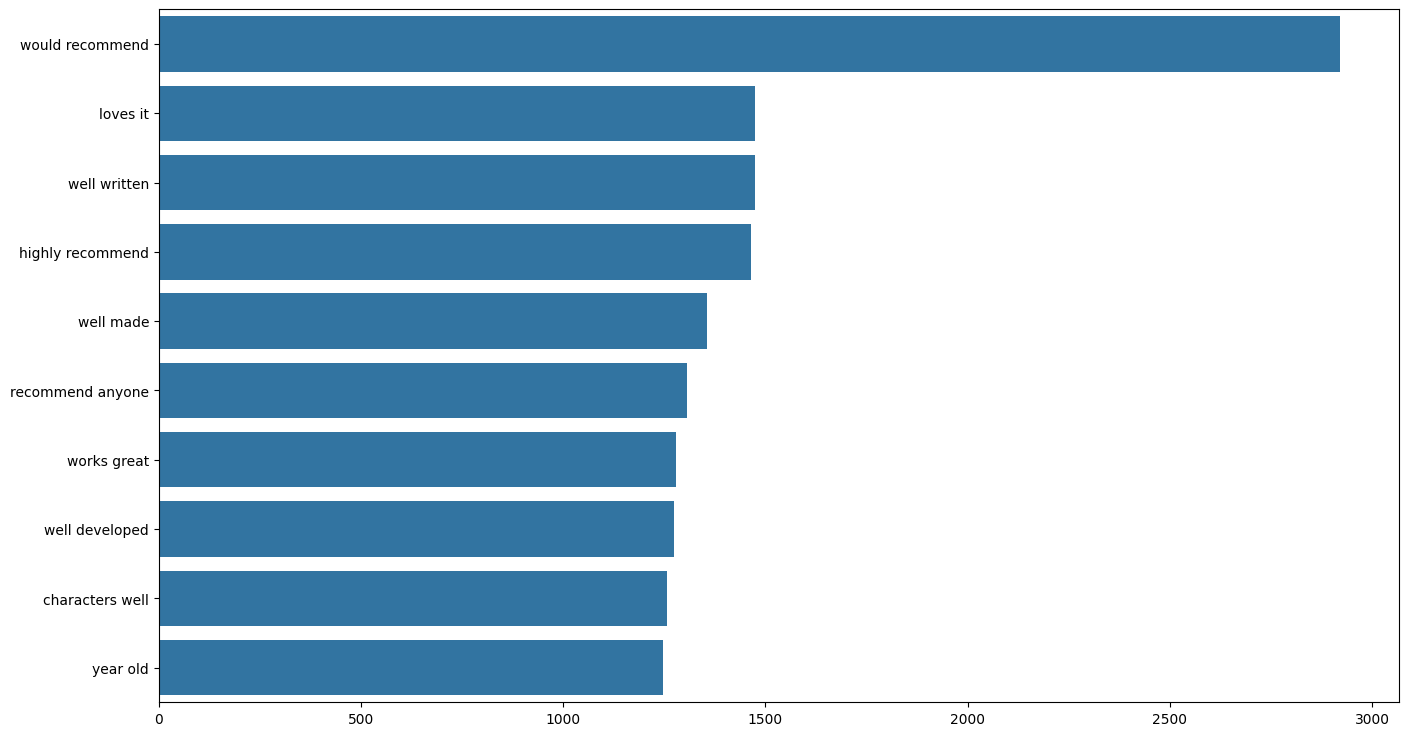

In [ ]:
plt.figure(figsize = (16,9))
most_common_bi = get_top_text_ngrams(df.text_,10,2)
most_common_bi = dict(most_common_bi)
sns.barplot(x=list(most_common_bi.values()),y=list(most_common_bi.keys()))

In [ ]:
#look at the latest condition of the dataset
df.head(n = 10).style.background_gradient(cmap = "summer")

,category,rating,label,text_
0,Home_and_Kitchen_5,5,CG,"Love this! Well made, sturdy, comfortable. love it!Very pretty"
1,Home_and_Kitchen_5,5,CG,"love it, great upgrade original. I've mine couple years"
2,Home_and_Kitchen_5,5,CG,pillow saved back. love look feel pillow.
3,Home_and_Kitchen_5,1,CG,"Missing information use it, great product price!"
4,Home_and_Kitchen_5,5,CG,nice set. Good quality. set two months
5,Home_and_Kitchen_5,3,CG,WANTED DIFFERENT FLAVORS NOT.
6,Home_and_Kitchen_5,5,CG,perfect touch thing wish little space.
7,Home_and_Kitchen_5,3,CG,done fit well look great. love smoothness edges extra
8,Home_and_Kitchen_5,5,CG,"Great big numbers easy read, thing like size"
9,Home_and_Kitchen_5,5,CG,son loves comforter well made. also baby


In [ ]:
df.tail(n = 10).style.background_gradient(cmap = "summer")

,category,rating,label,text_
40422,Clothing_Shoes_and_Jewelry_5,4,CG,"wore 4pm 9pm perfect. reason ordered size 6 front shoe slightly tight. would definitely go size. size 6 perfect me. ordered size 7 fit perfectly! give boots shot break in. would recommend anyone.I love boots. fit well comfortable.I bought mom, loves it! got size small fits great! exactly looking looks great! happy purchase definitely buying another color future.Very comfortable, little narrow, give shot. daughter tall, length one really short. thought little short, glad think that. material soft, comfortable problems it. thing would say little small me. problems it. would recommend small large, guy, like it. color beautiful love style. quality nice colors wonderful. would recommend anyone looking bright, casual look. ordered size up, fits fine.I bought shoes husband loves them! fit perfect. wears everyday"
40423,Clothing_Shoes_and_Jewelry_5,4,OR,"classy looking watch. get much opportunity ""dress up"" days, nice inexpensive watch ""on reserve"" events happen. Typically I'm wearing casio tough solar watch suit, look right (even good representation ""the real me""). Armitron I'll appropriate watch wear ""occasionally"". may want pick watch sizing kit, one I'm buying watches online days. one have: GGI International WTK-037 Metal Watch Repair Kit highly rated. easier taking watch shop. live household 6, whenever anyone gets watch adjust easily. think lack calendar function huge plus. Calendar functions never work well, whenever month 30 days calendar ""off"" fiddle it. many ways know proper date, like cell phone computer, need watch provide information. time fine. fit comfortable. red color pleasing worn dressy dressy casual clothing. negatives: 1) presentation box arrived damaged, going give gift would undesirable. give 5 stars: well, would something thought truly excellent made stand field. Also time review clear retail price is. nice watch, like it, really know good value is. I'll come back later update comes back stock."
40424,Clothing_Shoes_and_Jewelry_5,3,CG,"kind feel giving 3 star nice piece jewelry pearls best. band light inside pretty little smaller like. size ok necklace attractive. I'm looking forward wearing long time.I love boots! got size small fit perfect. I'm 5'6"" they're bit tight me, they're tight either. They're super cute!I bought wife loves them. little big wear work day, lot walking active. also pairs ones tried small. said small, true. also thought fit little tight her. said heel part boots soft, tight able walk them. size 11 boots fit perfectly. would definitely recommend boots!I worried would little bigger expecting, fits perfectly. color little different picture, still pretty beautiful love it. quality nice too, would definitely buy more!Bought daughter Christmas. loved it. cute fits perfect. happy it. gift her. wears everyday."
40425,Clothing_Shoes_and_Jewelry_5,5,OR,"stated dimensions description overstated usable space bag. find outside bag alone 7.5 x 6.75 x 3. said bag still large enough anything need hurry. Definitely enough comprehensive first aid kit. use mine possible bag instead. metal rings attached back hold shoulder strap enough organization room inside essentials. enough webbing outside mount extra things might need. Mine holds extra knife tomahawk. platform mounted hunting ruck go pack peel bag off, deploy shoulder strap, off. zippers nice mid duty covered. Covered enough ward dust debris light water. Dont get wrong nowhere near waterproof covering adds resistance. mounting platform comes retaining straps secure bag accidental loss Velcro fail. webbing inside bag elastic minus retaining strap pockets allowing secure load without rattle around. Overall nice bag. must disclose received product discount thorough testing evaluation honest unbiased review. aware people disregard reviews reviewers received discount think review genuine. assure case. depend reviews purchases attempt provide information would also look products

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [ ]:
# Check if your DataFrame is loaded correctly and not empty
print("Shape of df:", df.shape)
print(df.head())  # Display first few rows of the DataFrame


Shape of df: (40420, 4)
             category  rating label  \
0  Home_and_Kitchen_5       5    CG   
1  Home_and_Kitchen_5       5    CG   
2  Home_and_Kitchen_5       5    CG   
3  Home_and_Kitchen_5       1    CG   
4  Home_and_Kitchen_5       5    CG   

                                               text_  
0  Love this! Well made, sturdy, comfortable. lov...  
1  love it, great upgrade original. I've mine cou...  
2          pillow saved back. love look feel pillow.  
3   Missing information use it, great product price!  
4             nice set. Good quality. set two months  


In [ ]:
# Ensure 'text_' and 'label' columns exist in DataFrame
if 'text_' not in df.columns:
    print("Column 'text_' not found in DataFrame.")
if 'label' not in df.columns:
    print("Column 'label' not found in DataFrame.")


In [ ]:
#preparing the dataset for models

In [ ]:
# Preparing the dataset for models
x = df["text_"]
y = df["label"]

In [ ]:
# Map string labels to numeric values
label_mapping = {'CG': 0, 'OR': 1, '…':2}  # Replace '…' with actual labels
df['label'] = df['label'].map(label_mapping)

# Now convert to integers
y = df['label'].astype(int)

In [ ]:
# Check if your data is loaded correctly and not empty
print("Shape of x:", x.shape)
print("Shape of y:", y.shape)


Shape of x: (40420,)
Shape of y: (40420,)


In [ ]:
# Split the data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, shuffle=True, random_state=11)

In [ ]:
print("Shape of the train data: ",x_train.shape)
print("Shape of the test data: ",x_test.shape)

Shape of the train data:  (32336,)
Shape of the test data:  (8084,)


In [ ]:
tokenizer = Tokenizer(num_words = 10000)
tokenizer.fit_on_texts(x_train)

tokenized_train = tokenizer.texts_to_sequences(x_train)
tokenized_test = tokenizer.texts_to_sequences(x_test)

train_x = sequence.pad_sequences(tokenized_train, maxlen = 300)
test_x = sequence.pad_sequences(tokenized_test, maxlen = 300)

In [ ]:
# Prepare embedding matrix (assuming you're training embeddings as part of the model)
word_index = tokenizer.word_index
nb_words = min(10000, len(word_index)) + 1  # Adding 1 because of reserved 0 index for padding
embedding_dim = 100  # Example embedding dimension

# Example of initializing embedding matrix with random values (you can modify this based on your approach)
embedding_matrix = np.random.randn(nb_words, embedding_dim)

In [ ]:
lr_reduce = ReduceLROnPlateau(monitor = "val_accuracy", patience = 2, factor = 0.5, min_lr = 0.00001)

In [ ]:
#building the model

In [ ]:
model = Sequential()

model.add(Embedding(input_dim=nb_words,
                    output_dim=embedding_dim,
                    weights=[embedding_matrix],
                    input_length=300,
                    trainable=False))
model.add(Bidirectional(LSTM(150))),

model.add(Dense(units = 32,
                activation = "relu"))
model.add(Dense(1,
                activation = "sigmoid"))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 100)          1000100   
                                                                 
 bidirectional (Bidirection  (None, 300)               301200    
 al)                                                             
                                                                 
 dense (Dense)               (None, 32)                9632      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1310965 (5.00 MB)
Trainable params: 310865 (1.19 MB)
Non-trainable params: 1000100 (3.82 MB)
_________________________________________________________________


In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# compile the model
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01),
              loss = "binary_crossentropy",
              metrics = ["accuracy"])

In [ ]:
# Learning rate reduction callback
lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', patience=2, factor=0.5, min_lr=0.00001)


In [ ]:
history = model.fit(train_x,
                    y_train,
                    batch_size = 128,
                    validation_data = (test_x, y_test),
                    epochs = 5,
                    callbacks = [lr_reduce])


Epoch 1/5
253/253 [==============================] - 625s 2s/step - loss: 0.4324 - accuracy: 0.7890 - val_loss: 0.2948 - val_accuracy: 0.8711 - lr: 0.0100
Epoch 2/5
253/253 [==============================] - 620s 2s/step - loss: 0.2556 - accuracy: 0.8912 - val_loss: 0.2582 - val_accuracy: 0.8857 - lr: 0.0100
Epoch 3/5
253/253 [==============================] - 619s 2s/step - loss: 0.1875 - accuracy: 0.9241 - val_loss: 0.2593 - val_accuracy: 0.8884 - lr: 0.0100
Epoch 4/5
253/253 [==============================] - 626s 2s/step - loss: 0.1562 - accuracy: 0.9369 - val_loss: 0.2624 - val_accuracy: 0.8968 - lr: 0.0100
Epoch 5/5
253/253 [==============================] - 620s 2s/step - loss: 0.1336 - accuracy: 0.9467 - val_loss: 0.3006 - val_accuracy: 0.8841 - lr: 0.0100


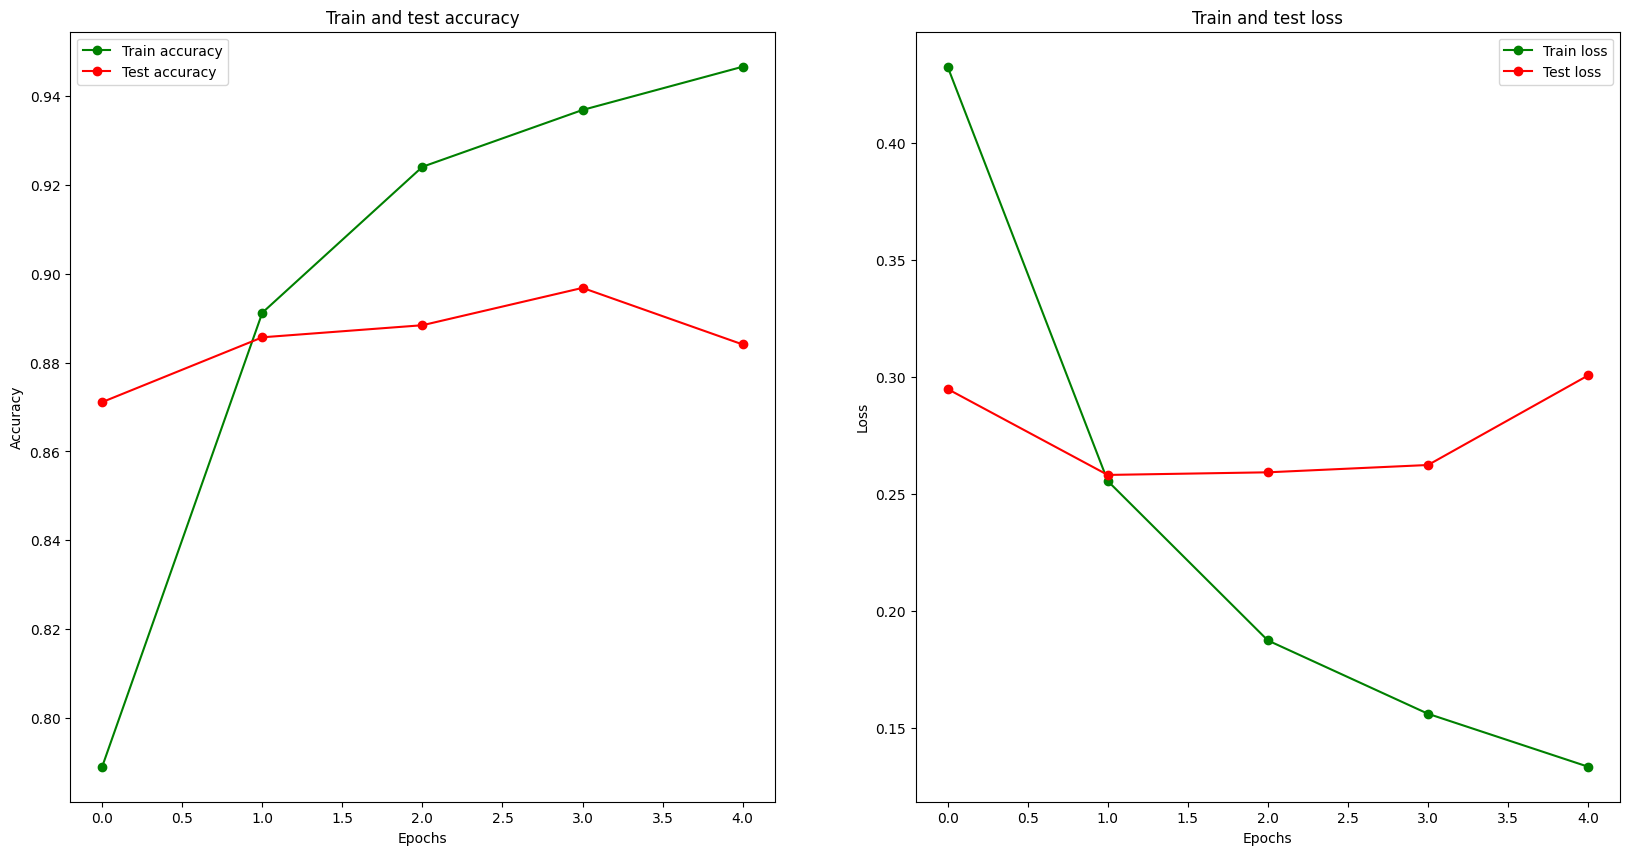

In [ ]:
epochs = [i for i in range(5)]

fig, ax = plt.subplots(1, 2)
train_acc = history.history["accuracy"]
train_loss = history.history["loss"]
val_acc = history.history["val_accuracy"]
val_loss = history.history["val_loss"]
fig.set_size_inches(20, 10)

ax[0].plot(epochs, train_acc, "go-", label = "Train accuracy")
ax[0].plot(epochs, val_acc, "ro-", label = "Test accuracy")
ax[0].set_title("Train and test accuracy")
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs, train_loss, "go-", label = "Train loss")
ax[1].plot(epochs, val_loss, "ro-", label = "Test loss")
ax[1].set_title("Train and test loss")
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()


In [ ]:
# make prediction
predictions = (model.predict(test_x) > 0.5).astype("int32")

253/253 [==============================] - 106s 412ms/step


In [ ]:
# calc the classes pred
classes_pred = np.argmax(predictions, axis = 1)

print(classification_report(y_test, classes_pred))

              precision    recall  f1-score   support

           0       0.50      1.00      0.67      4047
           1       0.00      0.00      0.00      4037

    accuracy                           0.50      8084
   macro avg       0.25      0.50      0.33      8084
weighted avg       0.25      0.50      0.33      8084



In [ ]:
print("Accuracy of the model on Training Data is - " , model.evaluate(train_x,y_train)[1]*100 , "%")
print("*********************************************************************************************")
print("Accuracy of the model on Testing Data is - " , model.evaluate(test_x,y_test)[1]*100 , "%")

1011/1011 [==============================] - 376s 372ms/step - loss: 0.1304 - accuracy: 0.9514
Accuracy of the model on Training Data is -  95.13854384422302 %
*********************************************************************************************
253/253 [==============================] - 93s 366ms/step - loss: 0.3006 - accuracy: 0.8841
Accuracy of the model on Testing Data is -  88.40920329093933 %


In [ ]:
cm = confusion_matrix(y_test,predictions)
cm

array([[3298,  749],
       [ 188, 3849]])

In [ ]:
cm = pd.DataFrame(cm , index = ['Fake','Original'] , columns = ['Fake','Original'])

Text(33.222222222222214, 0.5, 'Actual')

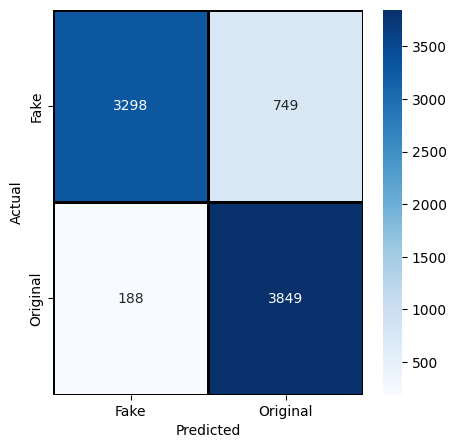

In [ ]:
plt.figure(figsize = (5,5))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Fake','Original'] , yticklabels = ['Fake','Original'])
plt.xlabel("Predicted")
plt.ylabel("Actual")

In [ ]:
#CNN

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense

In [ ]:
df = pd.read_csv('/content/fake reviews dataset (1).csv')

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['text_'], df['label'], test_size=0.2, random_state=42)

In [ ]:
# Tokenize and pad the text data
max_words = 5000
tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

max_len = max(len(seq) for seq in X_train_sequences)
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_len, padding='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_len, padding='post')

In [ ]:
# Encode the labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [ ]:
# Build the CNN model
embedding_dim = 50
num_filters = 64
filter_size = 3

model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len))
model.add(Conv1D(filters=num_filters, kernel_size=filter_size, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(units=1, activation='sigmoid'))

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the model
model.fit(X_train_padded, y_train_encoded, epochs=10, validation_data=(X_test_padded, y_test_encoded))

Epoch 1/10
1011/1011 [==============================] - 10s 9ms/step - loss: 0.3118 - accuracy: 0.8727 - val_loss: 0.2096 - val_accuracy: 0.9184
Epoch 2/10
1011/1011 [==============================] - 9s 9ms/step - loss: 0.1474 - accuracy: 0.9452 - val_loss: 0.1739 - val_accuracy: 0.9315
Epoch 3/10
1011/1011 [==============================] - 9s 9ms/step - loss: 0.0889 - accuracy: 0.9686 - val_loss: 0.1762 - val_accuracy: 0.9340
Epoch 4/10
1011/1011 [==============================] - 9s 9ms/step - loss: 0.0544 - accuracy: 0.9829 - val_loss: 0.1857 - val_accuracy: 0.9364
Epoch 5/10
1011/1011 [==============================] - 9s 9ms/step - loss: 0.0336 - accuracy: 0.9903 - val_loss: 0.2008 - val_accuracy: 0.9379
Epoch 6/10
1011/1011 [==============================] - 9s 9ms/step - loss: 0.0207 - accuracy: 0.9946 - val_loss: 0.2182 - val_accuracy: 0.9317
Epoch 7/10
1011/1011 [==============================] - 9s 9ms/step - loss: 0.0119 - accuracy: 0.9976 - val_loss: 0.2381 - val_accuracy

In [ ]:
# Evaluate the model on the test set
y_pred_prob = model.predict(X_test_padded)
y_pred = (y_pred_prob > 0.5).astype(int)

253/253 [==============================] - 1s 2ms/step


In [ ]:
# Convert predictions back to original labels
y_pred_labels = label_encoder.inverse_transform(y_pred.flatten())

In [ ]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_labels)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 93.26%


253/253 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       0.94      0.93      0.93      4016
           1       0.93      0.94      0.93      4071

    accuracy                           0.93      8087
   macro avg       0.93      0.93      0.93      8087
weighted avg       0.93      0.93      0.93      8087



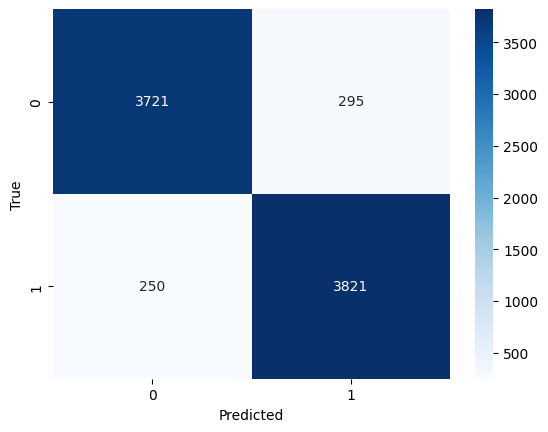

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
# Display classification report and confusion matrix
y_pred_prob = model.predict(X_test_padded)
y_pred = (y_pred_prob > 0.5).astype(int)
print(classification_report(y_test_encoded, y_pred))
conf_mat = confusion_matrix(y_test_encoded, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
#ANN

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense

In [ ]:
df = pd.read_csv('/content/fake reviews dataset (1).csv')

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['text_'], df['label'], test_size=0.2, random_state=42)

In [ ]:
# Tokenize and pad the text data
max_words = 5000
tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

max_len = max(len(seq) for seq in X_train_sequences)
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_len, padding='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_len, padding='post')


In [ ]:
# Encode the labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [ ]:
# Build the ANN model
embedding_dim = 50
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the model
model.fit(X_train_padded, y_train_encoded, epochs=10, validation_data=(X_test_padded, y_test_encoded))


Epoch 1/10
1011/1011 [==============================] - 13s 12ms/step - loss: 0.0586 - accuracy: 0.9818 - val_loss: 0.1790 - val_accuracy: 0.9346
Epoch 2/10
1011/1011 [==============================] - 11s 11ms/step - loss: 0.0362 - accuracy: 0.9897 - val_loss: 0.1973 - val_accuracy: 0.9322
Epoch 3/10
1011/1011 [==============================] - 7s 6ms/step - loss: 0.0219 - accuracy: 0.9945 - val_loss: 0.2091 - val_accuracy: 0.9345
Epoch 4/10
1011/1011 [==============================] - 6s 6ms/step - loss: 0.0127 - accuracy: 0.9975 - val_loss: 0.2331 - val_accuracy: 0.9348
Epoch 5/10
1011/1011 [==============================] - 6s 6ms/step - loss: 0.0070 - accuracy: 0.9989 - val_loss: 0.2510 - val_accuracy: 0.9325
Epoch 6/10
1011/1011 [==============================] - 6s 5ms/step - loss: 0.0039 - accuracy: 0.9996 - val_loss: 0.2991 - val_accuracy: 0.9304
Epoch 7/10
1011/1011 [==============================] - 6s 6ms/step - loss: 0.0025 - accuracy: 0.9998 - val_loss: 0.2954 - val_accur

In [ ]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test_padded, y_test_encoded)
print(f"Accuracy: {accuracy * 100:.2f}%")

253/253 [==============================] - 1s 2ms/step - loss: 0.3589 - accuracy: 0.9314
Accuracy: 93.14%


253/253 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.94      0.93      0.93      4016
           1       0.93      0.94      0.93      4071

    accuracy                           0.93      8087
   macro avg       0.93      0.93      0.93      8087
weighted avg       0.93      0.93      0.93      8087



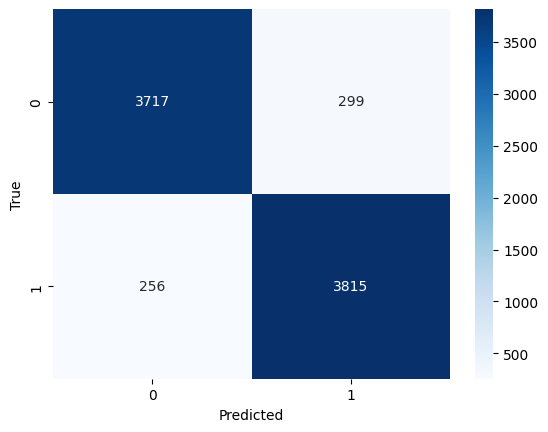

In [ ]:
# Display classification report and confusion matrix
y_pred_prob = model.predict(X_test_padded)
y_pred = (y_pred_prob > 0.5).astype(int)
print(classification_report(y_test_encoded, y_pred))
conf_mat = confusion_matrix(y_test_encoded, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
#hybrid model

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Flatten, Dense, Conv1D, GlobalMaxPooling1D, concatenate


In [ ]:
# Load the dataset
df = pd.read_csv('/content/fake reviews dataset (1).csv')


In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['text_'], df['label'], test_size=0.2, random_state=42)


In [ ]:
# Tokenize and pad the text data
max_words = 5000
tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

max_len = max(len(seq) for seq in X_train_sequences)
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_len, padding='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_len, padding='post')


In [ ]:
# Encode the labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)


In [ ]:
# Build the CNN model
embedding_dim = 50
num_filters = 64
filter_size = 3

cnn_model = Sequential()
cnn_model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len))
cnn_model.add(Conv1D(filters=num_filters, kernel_size=filter_size, activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(units=128, activation='relu'))


In [ ]:
# Build the ANN model
ann_model = Sequential()
ann_model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len))
ann_model.add(Flatten())
ann_model.add(Dense(128, activation='relu'))


In [ ]:
# Combine both models
combined_input = concatenate([cnn_model.output, ann_model.output])
combined_output = Dense(1, activation='sigmoid')(combined_input)

hybrid_model = Model(inputs=[cnn_model.input, ann_model.input], outputs=combined_output)


In [ ]:
# Compile the hybrid model
hybrid_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
# Train the hybrid model
hybrid_model.fit([X_train_padded, X_train_padded], y_train_encoded, epochs=10, validation_data=([X_test_padded, X_test_padded], y_test_encoded))


Epoch 1/10
1011/1011 [==============================] - 17s 15ms/step - loss: 0.1534 - accuracy: 0.9377 - val_loss: 0.0931 - val_accuracy: 0.9661
Epoch 2/10
1011/1011 [==============================] - 15s 15ms/step - loss: 0.0359 - accuracy: 0.9882 - val_loss: 0.1199 - val_accuracy: 0.9618
Epoch 3/10
1011/1011 [==============================] - 15s 15ms/step - loss: 0.0089 - accuracy: 0.9974 - val_loss: 0.1077 - val_accuracy: 0.9661
Epoch 4/10
1011/1011 [==============================] - 15s 15ms/step - loss: 0.0021 - accuracy: 0.9996 - val_loss: 0.1544 - val_accuracy: 0.9577
Epoch 5/10
1011/1011 [==============================] - 15s 15ms/step - loss: 0.0018 - accuracy: 0.9996 - val_loss: 0.3555 - val_accuracy: 0.9283
Epoch 6/10
1011/1011 [==============================] - 15s 15ms/step - loss: 0.0124 - accuracy: 0.9959 - val_loss: 0.2032 - val_accuracy: 0.9622
Epoch 7/10
1011/1011 [==============================] - 15s 15ms/step - loss: 0.0047 - accuracy: 0.9988 - val_loss: 0.1994 -

In [ ]:
# Evaluate the hybrid model on the test set
loss, accuracy = hybrid_model.evaluate([X_test_padded, X_test_padded], y_test_encoded)
print(f"Accuracy: {accuracy * 100:.2f}%")


253/253 [==============================] - 1s 3ms/step - loss: 0.2087 - accuracy: 0.9650
Accuracy: 96.50%


253/253 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

           0       0.97      0.96      0.96      4016
           1       0.96      0.97      0.97      4071

    accuracy                           0.97      8087
   macro avg       0.97      0.96      0.97      8087
weighted avg       0.97      0.97      0.97      8087



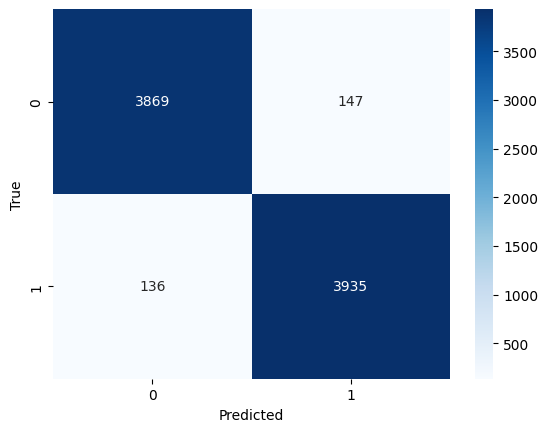

In [ ]:
# Display classification report and confusion matrix
y_pred_prob = hybrid_model.predict([X_test_padded, X_test_padded])
y_pred = (y_pred_prob > 0.5).astype(int)
print(classification_report(y_test_encoded, y_pred))
conf_mat = confusion_matrix(y_test_encoded, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()